## Outcome prediction after Chikungunya hospitalization

#### MC853 - Unicamp

- Leandro Henrique Silva Resende – 213437 

- Pietro Grazzioli Golfeto – 223694 

- Yvens Ian Prado Porto – 184031 

In [25]:
# Required Libraries
# We used Python 3.10.12
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import time

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (
    make_scorer, recall_score, precision_score, fbeta_score,
    f1_score, balanced_accuracy_score, roc_auc_score,
    average_precision_score
)

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [26]:
# Paths to the data (change according to your system)
leandro_path = {
    'X_train_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/X_train.csv',
    'y_train_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/y_train.csv',
    'X_test_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/X_test.csv',
    'y_test_path': '/home/leandro/Documentos/UNICAMP/MC853/DataSUS-Chikungunya-ML/datasets/y_test.csv',
}

pietro_path = {
    'X_train_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/X_train.csv',
    'y_train_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/y_train.csv',
    'X_test_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/X_test.csv',
    'y_test_path': '/home/pietro/Desktop/DataSUS-Chikungunya-ML/datasets/y_test.csv',
}

In [27]:
# Set the path based on the user
if os.path.isfile(leandro_path['X_train_path']):
    path = leandro_path
elif os.path.isfile(pietro_path['X_train_path']):
    path = pietro_path
else:
    raise Exception('Path not found. Please check the paths in the script.')

# Get CSV files path (modify to match your file path)
X_train_path = os.path.expanduser(path['X_train_path'])
y_train_path = os.path.expanduser(path['y_train_path'])
X_test_path = os.path.expanduser(path['X_test_path'])
y_test_path = os.path.expanduser(path['y_test_path'])

In [28]:
X_train = pd.read_csv(X_train_path, low_memory=False)
y_train = pd.read_csv(y_train_path, low_memory=False).squeeze("columns")
X_test = pd.read_csv(X_test_path, low_memory=False)
y_test = pd.read_csv(y_test_path, low_memory=False).squeeze("columns")

In [29]:
X_train.head()

,AGE,GENDER,PREGNANT,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,...,REGION_MIDWEST,REGION_SOUTHEAST,REGION_SOUTH,TIME_DIFF_DAYS,TIME,WHITE,BLACK,YELLOW,BROWN,INDIGENOUS
0,10.0,0,0.0,1,1,1,1,0,1,1,...,0,0,0,1,26,0,0,0,1,0
1,29.0,1,0.0,1,1,1,1,0,1,1,...,0,0,0,5,25,0,0,0,1,0
2,11.0,1,0.0,1,1,1,0,0,0,0,...,0,0,0,2,37,0,0,0,1,0
3,5.0,1,0.0,1,0,1,0,0,1,0,...,0,0,0,31,38,0,0,0,1,0
4,11.0,1,0.0,1,1,1,0,0,0,0,...,0,0,0,3,32,0,0,0,1,0


In [30]:
X_train.columns

Index(['AGE', 'GENDER', 'PREGNANT', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA',
       'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA',
       'PETEQUIA_N', 'LEUCOPENIA', 'LACO', 'DOR_RETRO', 'DIABETES',
       'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA', 'ACIDO_PEPT',
       'AUTO_IMUNE', 'CONFIRMED_CASE', 'CRITERIO', 'REGION_NORTH',
       'REGION_NORTHEAST', 'REGION_MIDWEST', 'REGION_SOUTHEAST',
       'REGION_SOUTH', 'TIME_DIFF_DAYS', 'TIME', 'WHITE', 'BLACK', 'YELLOW',
       'BROWN', 'INDIGENOUS'],
      dtype='object')

In [31]:
X_train[['AGE', 'TIME_DIFF_DAYS', 'TIME']].head()

,AGE,TIME_DIFF_DAYS,TIME
0,10.0,1,26
1,29.0,5,25
2,11.0,2,37
3,5.0,31,38
4,11.0,3,32


In [32]:
# # Drop CRITERIO column (not relevant alongside CONFIRMED_CASE)
X_train['CRITERIO'].value_counts()
X_train = X_train.drop(columns=['CRITERIO'])
X_test = X_test.drop(columns=['CRITERIO'])

In [33]:
def impute_missing(data_train, data_test, n_neighbors=3):
    """
    Impute missing values using the K-nearest neighbors algorithm.

    Parameters:
        data (pd.DataFrame): Input DataFrame with missing values.
        n_neighbors (int, optional): Number of neighbors to use for imputation. Defaults to 3.

    Returns:
        pd.DataFrame: DataFrame with missing values imputed using KNN.
    """
    # Initialize KNNImputer with the specified number of neighbors
    imputer = KNNImputer(n_neighbors=n_neighbors)

    # Perform imputation
    imputed_data_train = imputer.fit_transform(data_train)
    imputed_data_test = imputer.transform(data_test)

    # Convert the imputed array back to a DataFrame
    imputed_df_train = pd.DataFrame(imputed_data_train, columns=data_train.columns, index=data_train.index)
    imputed_df_test = pd.DataFrame(imputed_data_test, columns=data_test.columns, index=data_test.index)

    return imputed_df_train, imputed_df_test


In [34]:
# Impute missing values in the training and test sets using KNN
X_train, X_test = impute_missing(X_train, X_test, n_neighbors=3)

In [35]:
def remove_outliers(X, y, col, thresh):
    """
    Keep only rows where X[col] <= thresh and drop the others in both X and its matching y.
    """
    keep_mask = X[col] <= thresh          # boolean mask
    X_clean   = X.loc[keep_mask].reset_index(drop=True)
    y_clean   = y.loc[keep_mask].reset_index(drop=True)
    print(f"Removed {len(X) - len(X_clean)} outliers from {col} > {thresh}")
    return X_clean, y_clean

In [36]:
# Remove rows where TIME_DIFF_DAYS > 45 -> consider as outliers
print("Train set:")
X_train, y_train = remove_outliers(X=X_train, y=y_train, col='TIME_DIFF_DAYS', thresh=45)

print("Test set:")
X_test , y_test  = remove_outliers(X=X_test , y=y_test, col='TIME_DIFF_DAYS', thresh=45)

Train set:
Removed 743 outliers from TIME_DIFF_DAYS > 45
Test set:
Removed 239 outliers from TIME_DIFF_DAYS > 45


In [37]:
# Continuos features before scaling
X_train[['AGE', 'TIME_DIFF_DAYS', 'TIME']].describe()

,AGE,TIME_DIFF_DAYS,TIME
count,20983.000000,20983.000000,20983.000000
mean,32.964829,8.174522,160.614974
std,23.838605,8.008934,102.798928
min,0.000000,0.000000,0.000000
25%,12.000000,3.000000,66.000000
50%,30.000000,6.000000,155.000000
75%,51.000000,10.000000,263.000000
max,119.000000,45.000000,313.000000


In [38]:
# Scale the features using RobustScaler
# RobustScaler is robust to outliers and scales features to the interquartile range
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and test data
# Note: We only fit the scaler on the training data to avoid data leakage
# The scaler will be applied to the test data using the same parameters learned from the training data
X_train[['AGE', 'TIME_DIFF_DAYS', 'TIME']] = scaler.fit_transform(X_train[['AGE', 'TIME_DIFF_DAYS', 'TIME']])
X_test[['AGE', 'TIME_DIFF_DAYS', 'TIME']] = scaler.transform(X_test[['AGE', 'TIME_DIFF_DAYS', 'TIME']])

In [39]:
# Continuos features after scaling
X_train[['AGE', 'TIME_DIFF_DAYS', 'TIME']].describe()

,AGE,TIME_DIFF_DAYS,TIME
count,20983.000000,20983.000000,20983.000000
mean,0.076021,0.310646,0.028502
std,0.611246,1.144133,0.521822
min,-0.769231,-0.857143,-0.786802
25%,-0.461538,-0.428571,-0.451777
50%,0.000000,0.000000,0.000000
75%,0.538462,0.571429,0.548223
max,2.282051,5.571429,0.802030


In [40]:
# Check the distribution of the target variable in the training set
print(f"Train set target distribution: \n{y_train.value_counts(normalize=True)},\n")

# Check the distribution of the target variable in the test set
print(f"Test set target distribution: \n{y_test.value_counts(normalize=True)}")

Train set target distribution: 
EVOLUCAO
0    0.928418
1    0.071582
Name: proportion, dtype: float64,

Test set target distribution: 
EVOLUCAO
0    0.924028
1    0.075972
Name: proportion, dtype: float64


In [41]:
# Define the resampling pipeline that will be used on training data during cross-validation (not on validation data)
# SMOTE (Synthetic Minority Over-sampling Technique) is used to generate synthetic samples for the minority class
# RandomUnderSampler is used to randomly under-sample the majority class
resample_pipe = Pipeline(steps=[
    ('o', SMOTE(sampling_strategy=0.4, random_state=42)),
    ('u', RandomUnderSampler(sampling_strategy=1.0, random_state=42))
])

In [42]:
# Set the number of folds for cross-validation
# StratifiedKFold ensures that each fold has the same proportion of classes as the entire dataset
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# Define the hyperparameter grids for each model to be used in GridSearchCV
param_grids = {
    'knn': {
         'n_neighbors': [1, 3, 5, 10],
         'p': [1, 2],
         'weights': ['uniform', 'distance']
    },
    'logistic_regression': {
         # Use 'balanced' or a dict assigning more weight to class 1 (assuming class 0 weight stays 1)
         'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
    },
    'random_forest': {
         'n_estimators': [10, 100, 200],
         'max_depth': [10, 50],
         'min_samples_split': [2, 10, 30],
         'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]     
    }
}

In [44]:
# Define the base estimators models to be trained
# Each model will be trained using GridSearchCV with the specified hyperparameter grid
base_estimators = {
    'random_forest': RandomForestClassifier(random_state=0, n_jobs=-1),
    'logistic_regression': LogisticRegression(random_state=0, n_jobs=-1),
    'knn': KNeighborsClassifier(n_jobs=-1)
}

In [45]:
# Scorers for both classes
scoring_dict = {
    # class-1 (positive) metrics
    "recall_1"    : make_scorer(recall_score,    pos_label=1),
    "precision_1" : make_scorer(precision_score, pos_label=1, zero_division=0),
    "f1_1"        : make_scorer(f1_score,        pos_label=1, zero_division=0),
    "f2_1"        : make_scorer(fbeta_score,     beta=2, pos_label=1, zero_division=0),

    # class-0 (negative) metrics
    "recall_0"    : make_scorer(recall_score,    pos_label=0),
    "precision_0" : make_scorer(precision_score, pos_label=0, zero_division=0),
    "f1_0"        : make_scorer(f1_score,        pos_label=0, zero_division=0),
    "f2_0"        : make_scorer(fbeta_score,     beta=2, pos_label=0, zero_division=0),

    # class-agnostic metrics
    "balanced_acc": "balanced_accuracy",
    "roc_auc"     : "roc_auc",
    "pr_auc"      : "average_precision"
}

# Use recall of class 1 as the main scoring metric for model evaluation in GridSearchCV
# Recall is the ratio of true positives to the sum of true positives and false negatives
# It is a good metric to use when the cost of false negatives is high
# For example, in a medical diagnosis scenario, we want to minimize the number of false negatives
# (i.e., we want to correctly identify as many positive cases as possible)


In [46]:
"""
Build one GridSearchCV wrapper per base model
  • Uses the algorithm-specific hyper-parameter grids defined in param_grids
  • Shares the same StratifiedKFold object (kf) → every model sees identical
    train/validation splits during the search
  • Optimize models ONLY on recall of the positive class (label = 1) because
    missing a true-positive chikungunya case is the costliest error
  • refit='recall_1' ⇒ once the best hyper-params are found inside CV,
    retrain a fresh model on the entire (SMOTE+undersampled) training set.
    This ensures: (i) no data leakage; (ii) every final model has seen all
    available training samples before we evaluate on X_test later.
Result: `algorithms` is a dict whose values are fully configured GridSearchCV
        objects, ready to `.fit()` inside the evaluate_cv() function.
"""
algorithms = {}
for alg in base_estimators:
    algorithms[alg] = GridSearchCV(
        estimator  = base_estimators[alg],
        param_grid = param_grids[alg],
        cv         = kf, 
        n_jobs     = -1,                 # Use all CPU cores
        scoring    = scoring_dict,       # Store all metrics
        refit      = 'recall_1'          # Optimize for recall of class 1
    )

In [47]:
def evaluate_cv(X_train, y_train):
    """
    Outer 5-fold cross-validation for model-selection and performance
    estimation.

      • Each outer fold:
          1. resamples ONLY the training split (SMOTE + undersampling)
          2. runs the inner GridSearchCV (optimising recall_1, recording all metrics)
          3. evaluates the winning model on the held-out validation split

      • After the outer loop finishes, every GridSearchCV is refit on the
        entire resampled training set so that `best_estimator_` has seen all
        available data.

    Returns
    -------
    summary : pd.DataFrame        rows = metric (mean / std),  cols = model
    best_params_overall : dict    {model_name: final best hyper-params}
    """

    # Record the start time
    start_time = time.time()

    # Initialize dictionaries to store best hyperparameters and best grid-search scores for each fold
    fold_scores     = {m: {alg: [] for alg in algorithms} for m in scoring_dict}
    best_params_all = {alg: [] for alg in algorithms}
    best_scores_all = {alg: [] for alg in algorithms}
    # Candidate counts for logs
    candidates = {alg: np.prod([len(v) for v in param_grids[alg].values()]) for alg in param_grids}

    # Outer loop
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
        # Allocate train and validation data
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Resample only the training data (no leakage of validation data)
        X_train_fold_res, y_train_fold_res = resample_pipe.fit_resample(X_train_fold, y_train_fold)

        # Iterate through each algorithm (each wrapped with GridSearchCV)
        for alg, gs in algorithms.items():
            print(f"Fold {fold_idx} – {alg}: {candidates[alg]} candidates")
            # Inner GridSearchCV for hyper-parameter tuning
            gs.fit(X_train_fold_res, y_train_fold_res)
            
            # Keep track of the best hyperparameters and the best score from grid-search for this outer fold
            best_params_all[alg].append(gs.best_params_)
            best_scores_all[alg].append(gs.best_score_)
            
            # Evaluate the winning model on the held-out fold
            # Make predictions for the validation data (using the best estimator found)
            y_pred = gs.predict(X_val_fold)
            y_prob = gs.predict_proba(X_val_fold)[:, 1]

            def calc(metric_name):
                """
                Compute <metric_name> on the current outer-fold validation split.
                Raises ValueError if the key is not recognised.
                """

                # Probability-based metrics
                if   metric_name == "roc_auc":
                    return roc_auc_score(y_val_fold, y_prob)
                elif metric_name == "pr_auc":
                    return average_precision_score(y_val_fold, y_prob)

                # Class-agnostic metrics
                elif metric_name == "balanced_acc":
                    return balanced_accuracy_score(y_val_fold, y_pred)

                # Class-specific metrics must end with _0 or _1
                if not metric_name.endswith(("_0", "_1")):
                    raise ValueError(f"Unknown metric name: {metric_name}")

                # Class-specific metrics
                lbl  = 1 if metric_name.endswith("_1") else 0
                base = metric_name.split("_")[0]            # recall | precision | f1 | f2

                if   base == "recall":
                    return recall_score(y_val_fold, y_pred, pos_label=lbl, zero_division=0)
                elif base == "precision":
                    return precision_score(y_val_fold, y_pred, pos_label=lbl, zero_division=0)
                elif base == "f1":
                    return f1_score(y_val_fold, y_pred, pos_label=lbl, zero_division=0)
                elif base == "f2":
                    return fbeta_score(y_val_fold, y_pred, beta=2, pos_label=lbl, zero_division=0)

                # Prefix wasn’t one of the recognised options
                raise ValueError(f"Unknown metric name: {metric_name}")

            for m in scoring_dict:
                fold_scores[m][alg].append(calc(m))       

    # Create a DataFrame summary table with the mean and standard deviation of each algorithm's performance across CV folds
    metrics_summary = {}
    for m in scoring_dict:
        metrics_summary[f"{m} (mean)"] = {alg: np.mean(metrics) for alg, metrics in fold_scores[m].items()}
        metrics_summary[f"{m} (std)"]  = {alg: np.std(metrics) for alg, metrics in fold_scores[m].items()}
    summary = pd.DataFrame(metrics_summary).T   # Metrics in rows

    """
    Final refit on all training data

    Without the refit: After cross-validation finishes, each GridSearchCV object is fitted on only the 4 folds used in the final CV iteration.
    That leaves 20 % of the training data (the fold that happened to be “validation” in that iteration) completely unseen by the model later evaluated on X_test.

    With the refit: Train a fresh model—using the same best hyper-parameters found during CV on the entire training set (after SMOTE + undersampling).
    This guarantees that the test-set assessment uses a model that has seen all training data without leaking any information from the test set.
    """
    X_full_res, y_full_res = resample_pipe.fit_resample(X_train, y_train)

    # Refit each GridSearchCV on the entire resampled training set
    # This ensures that the best estimator is trained with all available data
    for gs in algorithms.values():
        gs.fit(X_full_res, y_full_res)

    # Store the best hyperparameters for each algorithm after refitting on the entire training set
    best_params_overall = {alg: gs.best_params_ for alg, gs in algorithms.items()}        

    # Record the end time and print total time taken
    end_time = time.time()
    print(f"\Total CV time: {end_time - start_time:.2f} seconds")
    
    return summary, best_params_overall

In [48]:
# Evaluate the models using cross-validation
# Performs the outer cross-validation, tune hyperparameters, and evaluate the models on the validation set
# Returns a summary of the metrics and the best hyperparameters for each model
cv_summary, best_params = evaluate_cv(X_train, y_train)

Fold 1 – random_forest: 54 candidates
Fold 1 – logistic_regression: 3 candidates
Fold 1 – knn: 16 candidates
Fold 2 – random_forest: 54 candidates
Fold 2 – logistic_regression: 3 candidates
Fold 2 – knn: 16 candidates
Fold 3 – random_forest: 54 candidates
Fold 3 – logistic_regression: 3 candidates
Fold 3 – knn: 16 candidates
Fold 4 – random_forest: 54 candidates
Fold 4 – logistic_regression: 3 candidates
Fold 4 – knn: 16 candidates
Fold 5 – random_forest: 54 candidates
Fold 5 – logistic_regression: 3 candidates
Fold 5 – knn: 16 candidates
\Total CV time: 498.51 seconds


In [49]:
print("=== Cross-validated metrics ===")
display(cv_summary)

=== Cross-validated metrics ===


,random_forest,logistic_regression,knn
recall_1 (mean),0.778970,0.914128,0.531269
recall_1 (std),0.032869,0.016540,0.030893
precision_1 (mean),0.117905,0.092786,0.120981
precision_1 (std),0.005359,0.001521,0.007636
f1_1 (mean),0.204793,0.168468,0.196826
f1_1 (std),0.009040,0.002697,0.009961
f2_1 (mean),0.367142,0.329947,0.315872
f2_1 (std),0.015550,0.005129,0.012159
recall_0 (mean),0.550382,0.310816,0.700733
recall_0 (std),0.014325,0.011108,0.030613


In [50]:
print("=== Final best hyper-parameters ===")
for alg, params in best_params.items():
    print(f"{alg}: {params}")

=== Final best hyper-parameters ===
random_forest: {'class_weight': {0: 1, 1: 3}, 'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 200}
logistic_regression: {'class_weight': {0: 1, 1: 3}}
knn: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}


In [54]:
def test_model(algorithms, X_test, y_test):
    """
    Final assessment on the held-out test set.
        • Uses the same `scoring_dict` as cross-validation
        • Returns a score results DataFrame:  rows = metrics, cols = model names
    """
    # Prepare an empty metric → model → value mapping
    scores = {m: {} for m in scoring_dict}

    for model_name, gs in algorithms.items():
        est   = gs.best_estimator_
        y_hat = est.predict(X_test)
        y_prob = (est.predict_proba(X_test)[:, 1] if hasattr(est, "predict_proba") else None)

        def calc(metric_name):
            """
            Compute <metric_name> on the current outer-fold validation split.
            Raises ValueError if the key is not recognised.
            """

            # Probability-based metrics
            if   metric_name == "roc_auc":
                return roc_auc_score(y_test, y_prob)
            elif metric_name == "pr_auc":
                return average_precision_score(y_test, y_prob)

            # Class-agnostic metrics
            elif metric_name == "balanced_acc":
                return balanced_accuracy_score(y_test, y_hat)

            # Class-specific metrics must end with _0 or _1
            if not metric_name.endswith(("_0", "_1")):
                raise ValueError(f"Unknown metric name: {metric_name}")

            # Class-specific metrics
            lbl  = 1 if metric_name.endswith("_1") else 0
            base = metric_name.split("_")[0]            # recall | precision | f1 | f2

            if   base == "recall":
                return recall_score(y_test, y_hat, pos_label=lbl, zero_division=0)
            elif base == "precision":
                return precision_score(y_test, y_hat, pos_label=lbl, zero_division=0)
            elif base == "f1":
                return f1_score(y_test, y_hat, pos_label=lbl, zero_division=0)
            elif base == "f2":
                return fbeta_score(y_test, y_hat, beta=2, pos_label=lbl, zero_division=0)

            # Prefix wasn’t one of the recognised options
            raise ValueError(f"Unknown metric name: {metric_name}")  

        # Fill the scores dict
        for m in scoring_dict:
            scores[m][model_name] = calc(m)

    # Return Dataframe (metrics as rows)
    return pd.DataFrame(scores).T


In [55]:
results_test = test_model(algorithms, X_test, y_test)
display(results_test)

,random_forest,logistic_regression,knn
recall_1,0.812500,0.916667,0.544271
precision_1,0.113848,0.096571,0.125037
f1_1,0.199712,0.174733,0.203357
f2_1,0.364784,0.339703,0.325799
recall_0,0.480034,0.294936,0.686864
precision_0,0.968885,0.977297,0.948271
f1_0,0.641993,0.453125,0.796672
f2_0,0.533911,0.342807,0.726943
balanced_acc,0.646267,0.605801,0.615568
roc_auc,0.722954,0.743524,0.646492


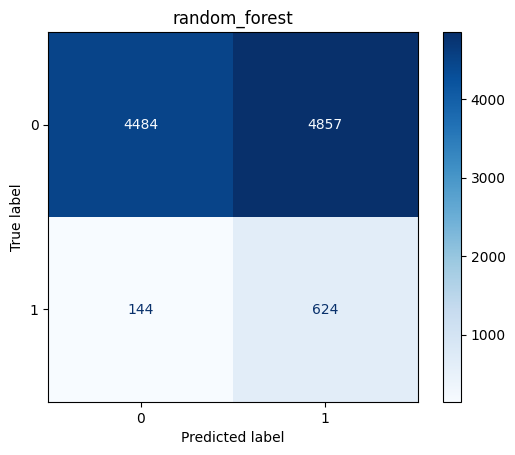

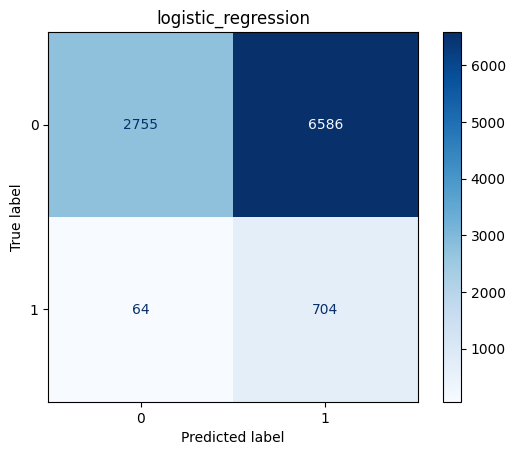

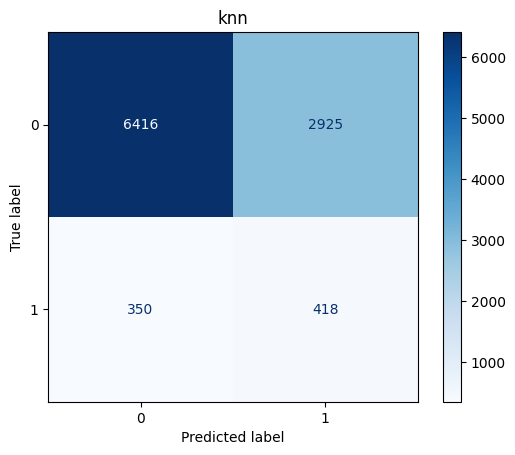

In [58]:
# Display the confusion matrix for each algorithm on the test set
# Shows the number of true positives, true negatives, false positives, and false negatives
for name, gs in algorithms.items():
    y_pred = gs.best_estimator_.predict(X_test)
    # plt.cm.Blues is a colormap that ranges from light blue (few values) to dark blue (many values)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=[0,1], colorbar=True, cmap=plt.cm.Blues)
    plt.title(name)
    plt.show()